# Time Frequency Analysis via Basis Pursuit

We implement the example given in [Steven Boyd's _convex optimization_ book](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf) §6.5.4, pp. 334-337

We will approximate a signal 
$$
\begin{align*}
y(t) \; &= \; a(t) \cdot \sin(\theta(t))
\quad & a(t) = 1 + 0.5\sin(11 t)
\quad & \theta(t) = 30 \sin(5 t)
\end{align*}
$$ 
with the $(K+1)\cdot(2L+1)$ basis functions
$$
\begin{align*}
f_{k, l, \cos}      \quad &= \quad 
e^{-\frac{(t-\tau_k)^2}{\sigma^2}} \cdot \cos(\omega_l t) 
                    \quad & \quad k = 0, 1, \ldots, K \quad & \quad l = 0, \ldots L \\
f_{k, l, \sin}      \quad &= \quad
e^{-\frac{(t-\tau_k)^2}{\sigma^2}} \cdot \sin(\omega_l t) 
                    \quad & \quad k = \;\;\;\, 1, \ldots, K \quad & \quad l = 0, \ldots L 
\end{align*}
$$

1. By using a penalizing $\Vert \cdot \Vert_1$-norm on the coefficient vector $x = (x_{k,l,{\rm tri}})$ will become very sparse.
2. After this heuristic identification of important basis functions, a least-squares approximation is run,
    reduced to the sparsity pattern of that sparse basis.
    This way, we save computing time.
3. Lastly, we do run the full least-squares approximation, i. e. *without* sparsity pattern, to get a feel on how much longer this
    takes compared to the runtime in 2.
    <br>
    We also compare the accuracy of the results between sparse and full approximation and find that the sparse approximation can easily keep up with the full approximation.

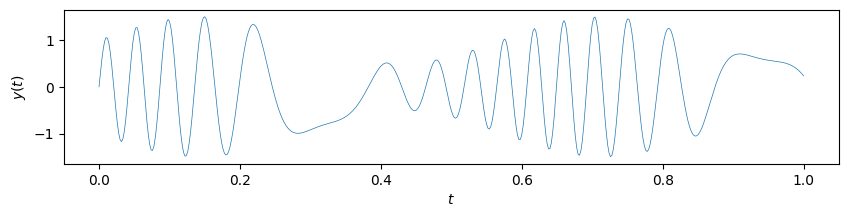

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# The following fcns operate on scalar `t` as well as on `np.ndarray` `t`. 
# If `t` is `np.ndarray`, the return value is `np.ndarray` as well.
a_fcn = lambda t: 1 + .5 * np.sin(11 * t)
theta_fcn = lambda t: 30 * np.sin(5 * t)
y_fcn = lambda t: a_fcn(t) * np.sin(theta_fcn(t))

m = 501

t = np.linspace(0, 1, m)
y = y_fcn(t)

fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(t, y, linewidth=.5)
ax.set(xlabel='$t$', ylabel='$y(t)$')
plt.show()

## (1) Basis pursuit:

Solve $\Vert\cdot\Vert_1$-norm problem to obtain relevant heuristic sparsity pattern of the basis functions $f_{k, l, {\rm tri}}$ for the signal $y$.

In [2]:
K = 501
L = 30

sigma = .05
tau = np.linspace(0, 1, K)
omega_cos = np.linspace(0, 5*L, L+1)
omega_sin = np.linspace(0, 5*L, L+1)[1:]

# transpose so that t runs along axis 0
exp_fcn = lambda t: np.array([ np.exp(-((t - tau_k) / sigma) ** 2) for tau_k in tau ]).T
# Putting sines first lets us have the constants (i. e. frequency 0) in the middle at tri_fcn(t)[:, L]
tri_fcn = lambda t: np.concatenate([ [ np.sin(omega_l * t) for omega_l in omega_sin ], [ np.cos(omega_l * t) for omega_l in omega_cos ] ], axis=0).T

exp = exp_fcn(t)
tri = tri_fcn(t)
A = np.array([
    np.outer(exp_i, tri_i)
    for exp_i, tri_i in zip(exp, tri)
])

gamma = cp.Parameter(nonneg=True)

A = A.reshape(m, K * ( 2 * L + 1 ))
x = cp.Variable( K * ( 2 * L + 1 ) )
obj = cp.sum_squares( A @ x - y ) + gamma * cp.norm1(x)

# Not reshaping makes the optimization slightly slower.
# This might be caused by some extra computations when multiplying the matrices in
# cp.trace(A_i.T @ x): The off-diagonal entries of the matrix product are not needed
# for the trace but computed nevertheless.
#
# x = cp.Variable((K, 2*L+1))
# obj = cp.sum_squares(
#     cp.vstack([
#         cp.trace(A_i.T @ x) - y_i
#         for A_i, y_i in zip(A, y)
#     ])
# ) + gamma * cp.norm1(x)

problem = cp.Problem(cp.Minimize(obj))
gamma.value = 1
problem.solve(verbose=False)
sparse_x = x.value

/Users/dhjn/.asdf/installs/python/3.11.1/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


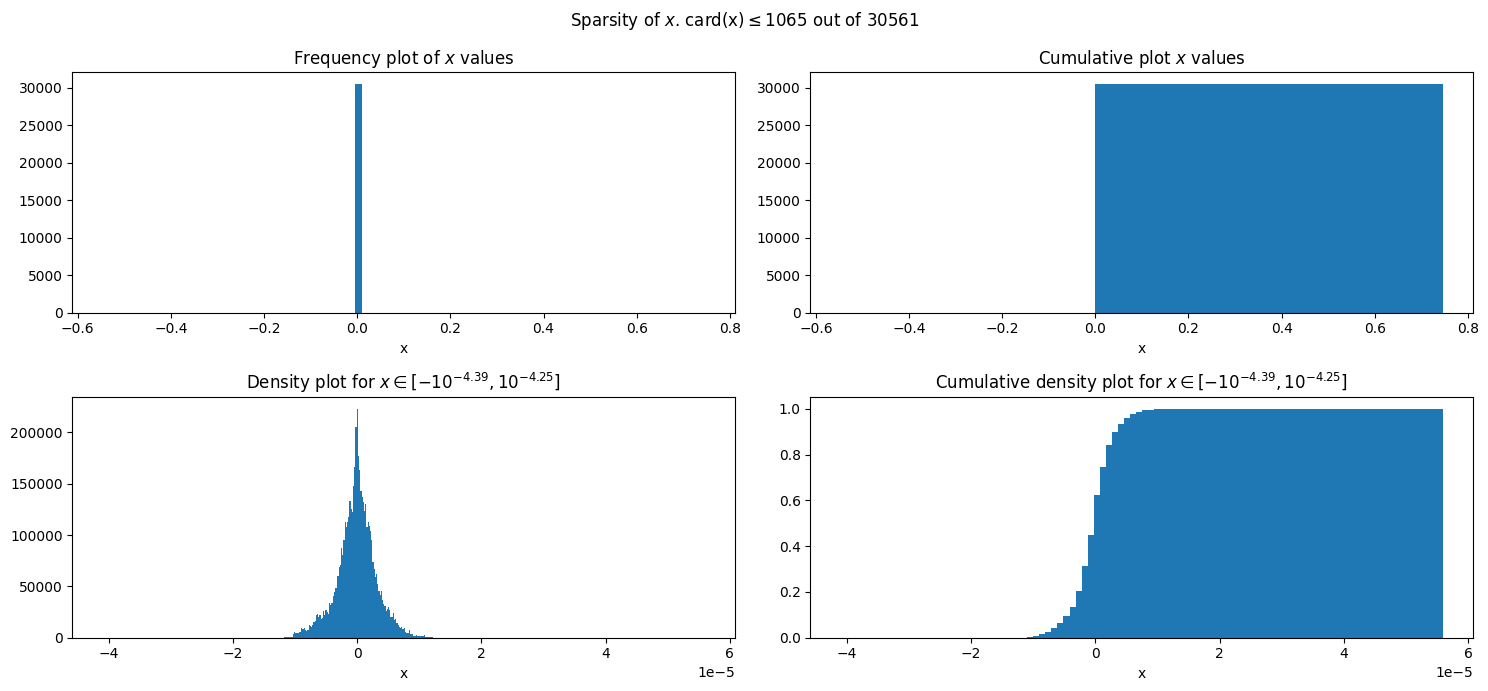

In [35]:
# Histogram plot of sparsity vector and approximation

squeeze = .75e-4
range_min, range_max = squeeze * np.min(sparse_x), squeeze * np.max(sparse_x)

zero_x = sparse_x[np.abs(sparse_x) < np.average([range_min, range_max])]


fig, axes = plt.subplots(2, 2, figsize=(15, 7))
fig.suptitle(f'Sparsity of $x$. $\\rm{{card}}(x) \\leq {len(sparse_x) - len(zero_x)} $ out of {len(sparse_x)}')

ax = axes[0, 0]
ax.set(
    title=f'Frequency plot of $x$ values',
    xlabel='x'
)
ax.hist(sparse_x, bins=100)

ax = axes[0, 1]
ax.set(
    title=f'Cumulative plot $x$ values',
    xlabel='x'
)
ax.hist(sparse_x, bins=500, cumulative=True)

ax = axes[1, 0]
ax.hist(sparse_x, bins=500, density=True, range=[range_min, range_max])
ax.set(
    title=f'Density plot for $x \in [-10^{{{np.round(np.log10(np.abs(range_min)), 2)}}}, 10^{{{np.round(np.log10(range_max), 2)}}}]$',
    xlabel='x'
)

ax = axes[1, 1]
ax.set(
    title=f'Cumulative density plot for $x \in [-10^{{{np.round(np.log10(np.abs(range_min)), 2)}}}, 10^{{{np.round(np.log10(range_max), 2)}}}]$',
    xlabel='x'
)
ax.hist(sparse_x, bins=100, density=True, cumulative=True, range=[range_min, range_max])

fig.tight_layout()
plt.show()

##### Performance Summary

On an Apple M1 Pro the basis pursuit in step 1. with parameters
* $\gamma = 1$
* $m = 501$ equidistant points in time $t_0, \ldots , t_{500}$
* $K = 501$ pulse centers $\tau_0, \ldots, \tau_{500}$ 
* $2 * L + 1 = 30 + 31 = 61$ frequencies $(\omega_0,) \omega_1, \ldots, \omega_{30}$
took about 5:30 minutes.

## (2) Solve Least-Squares with Sparsity Pattern from Step (1)

In [36]:
tol = 1e-4
pattern = np.where(np.abs(sparse_x) > tol)[0]
k = len(pattern)
tilde_A = A[:, pattern]

tilde_x = cp.Variable(k)
obj = cp.sum_squares(tilde_A @ tilde_x - y)
problem = cp.Problem(cp.Minimize(obj))
problem.solve(verbose=False)

0.03511094234167368

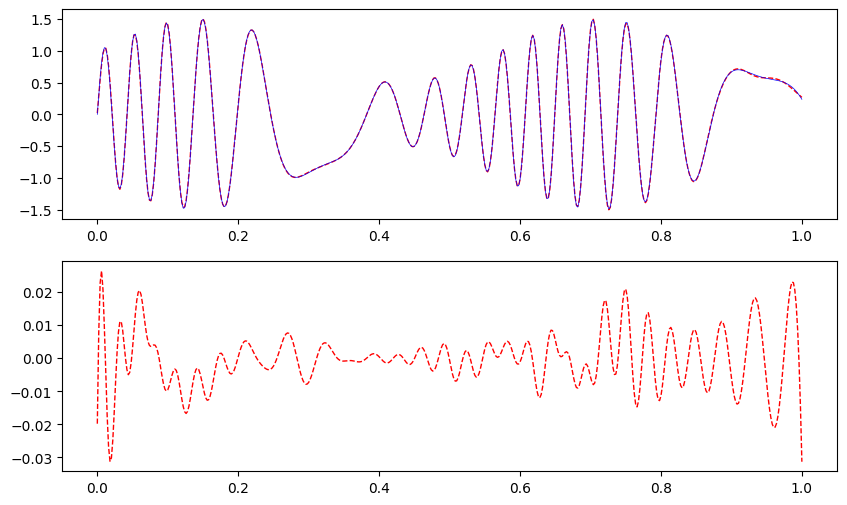

In [37]:
tilde_y = tilde_A @ tilde_x.value

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

ax = axes[0]
ax.plot(t, tilde_y, linewidth=1, color='red', linestyle='dashed')
ax.plot(t, y, linewidth=.5, color='blue')

ax = axes[1]
ax.plot(t, y - tilde_y, linewidth=1, color='red', linestyle='dashed')

plt.show()

First order approximation of frequency-phases $\theta(t)$ at pulse centers $\tau_k$

$$
\begin{align*}
\theta(t) \; &= \; \theta(\tau_k) + \theta^\prime(\tau_k) (t - \tau_k) \\
                \; &= \; 30 \sin(5\tau_k) - 150 \cos(5 \tau_k) \tau_k + 150 \cos(5 \tau_k) t \\
\omega(\tau_k) \; &= \; 150 \cos(5 \tau_k)
\end{align*}
$$

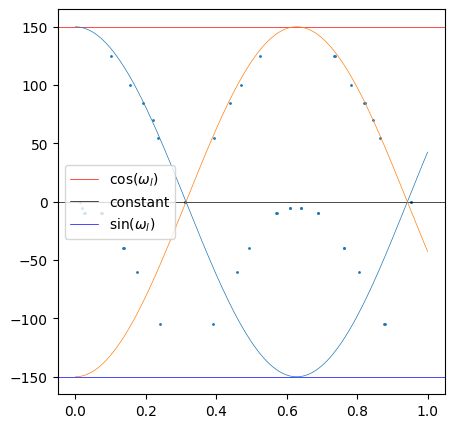

In [38]:
x_fit = np.zeros(K * (2 * L + 1))
x_fit[pattern] = tilde_x.value
x_fit = x_fit.reshape(K, 2 * L + 1)

sync_tau = np.array([
    np.ones(2 * L + 1) * tau_k for tau_k in tau
]).reshape(K * (2 * L + 1))

exact_frequencies = 150 * np.cos(5 * tau)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(sync_tau[pattern], 5 * (pattern % (2 * L + 1) - L), s=1)
ax.axhline( 5 * L, linewidth=.5, color='red'  , label='$\cos(\omega_l)$')
ax.axhline( 0    , linewidth=.5, color='black', label='constant')
ax.axhline(-5 * L, linewidth=.5, color='blue' , label='$\sin(\omega_l)$')
ax.plot(tau,  exact_frequencies, linewidth=.5)
ax.plot(tau, -exact_frequencies, linewidth=.5)
# ax.hist2d(hist_tau, np.abs(sparse_x), bins=(200, 200), cmin=1e-1)
# ax.hist2d(hist_tau, sparse_x, bins=(200, 200), cmax=1e-5)
# ax.hist2d(x_tau[k, :], np.ones(2 * L + 1) * tau[k], bins=(50, 50), alpha=.1, cmap=plt.get_cmap('Greys'))
ax.legend()

plt.show()